In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import tensorflow as tf
print (tf.test.gpu_device_name())

import sys
sys.path.append("/content/drive/My Drive/Colab/Research - EE5003/Phase 1 - Comparison of forecasting technique/")

Mounted at /content/drive/
/device:GPU:0


# **Data Preprocessing**

In [2]:
import time
import calendar
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid")

### **Feature Engineering**

In [3]:
# Find last Monday for holiday
def last_mon_date(year, month):
  """
  Returns a matrix representing a month’s calendar
  Each row represents a week; days outside of the month a represented by zeros
  Each week begins with Monday
  """
  cal = calendar.monthcalendar(year, month)
  last_mon_date = cal[4][0] if (cal[4][0] > 0) else cal[3][0]
  return str(year)+"-"+str(month)+"-"+str(last_mon_date)

def feature_engineering(df):
  
  df["time"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, "%m%d%Y %H:%M")) # Convert to timestamp from string 
  #df = df.set_index(["time"])

  df["Year"] = df["time"].apply(lambda x: x.year)
  df["Month"] = df["time"].apply(lambda x: x.month)
  df["Day"] = df["time"].apply(lambda x: x.day)
  df["Weekday"] = df["time"].apply(lambda x: x.weekday() + 1) # To adjust to 1 to 7 instead of 0 to 6
  df["Week"] = df["Day"].apply(lambda x: (x-1)//7+1)
  df["Weekend"] = df["Weekday"].apply(lambda x: 1 if x>=6 else 0) # Apply function to the column (default: axis=0)
  df["Hour"] = df["time"].apply(lambda x: x.hour)

  # Find last Monday in May
  unique_year = df["Year"].unique()
  last_mon_may = []
  for i in range(0, unique_year.shape[0], 1):
    last_mon_may.append(last_mon_date(unique_year[i], 5))
  last_mon_may = [time.mktime(datetime.datetime.strptime(x,"%Y-%m-%d").timetuple()) for x in last_mon_may] # Convert to timestamp

  df["Holiday"] = 0
  df["Holiday"] = df["time"].apply(lambda x: 1 if (datetime.datetime.timestamp(x) in last_mon_may) else 0)
  df["Holiday"].loc[(df["Month"] == 1) & (df["Day"] == 1)] = 1 # Remember () for condition
  df["Holiday"].loc[(df["Month"] == 12) & (df["Day"] == 25)] = 1
  df["Holiday"].loc[(df["Month"] == 11) & (df["Day"] == 11)] = 1
  df["Holiday"].loc[(df["Month"] == 7) & (df["Day"] == 4)] = 1
  df["Holiday"].loc[(df["Month"] == 1) & (df["Week"] == 3) & (df["Weekday"] == 1)] = 1
  df["Holiday"].loc[(df["Month"] == 2) & (df["Week"] == 3) & (df["Weekday"] == 1)] = 1 
  df["Holiday"].loc[(df["Month"] == 11) & (df["Week"] == 4) & (df["Weekday"] == 4)] = 1
  df["Holiday"].loc[(df["Month"] == 10) & (df["Week"] == 2) & (df["Weekday"] == 1)] = 1
  df["Holiday"].loc[(df["Month"] == 9) & (df["Week"] == 1) & (df["Weekday"] == 1)] = 1  

  df_sub = pd.get_dummies(df["Month"], drop_first=True, prefix="Month_")
  df_sub2 = pd.get_dummies(df["Weekday"], drop_first=True, prefix="Weekday_")
  df_sub3 = pd.get_dummies(df["Hour"], drop_first=True, prefix="Hour_")
  df = pd.concat([df, df_sub, df_sub2, df_sub3], axis=1)
  df = df.drop(["timestamp"], axis=1)

  return df

In [4]:
# os.listdir("/content/drive/My Drive/Colab/Research - EE5003")
df = pd.read_csv("/content/drive/My Drive/Colab/Research - EE5003/Final Modified Data_Rev2.csv")
df = feature_engineering(df)
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

,PV (kWh),Load (kWh),price (cents/kWh),time,Year,Month,Day,Weekday,Week,Weekend,Hour,Holiday,Month__2,Month__3,Month__4,Month__5,Month__6,Month__7,Month__8,Month__9,Month__10,Month__11,Month__12,Weekday__2,Weekday__3,Weekday__4,Weekday__5,Weekday__6,Weekday__7,Hour__1,Hour__2,Hour__3,Hour__4,Hour__5,Hour__6,Hour__7,Hour__8,Hour__9,Hour__10,Hour__11,Hour__12,Hour__13,Hour__14,Hour__15,Hour__16,Hour__17,Hour__18,Hour__19,Hour__20,Hour__21,Hour__22,Hour__23
0,0.0,2667.0,43.17,2011-01-01 00:00:00,2011,1,1,6,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,2525.0,36.24,2011-01-01 01:00:00,2011,1,1,6,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,2417.0,34.64,2011-01-01 02:00:00,2011,1,1,6,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,2373.0,33.76,2011-01-01 03:00:00,2011,1,1,6,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,2374.0,33.08,2011-01-01 04:00:00,2011,1,1,6,1,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Visualization**

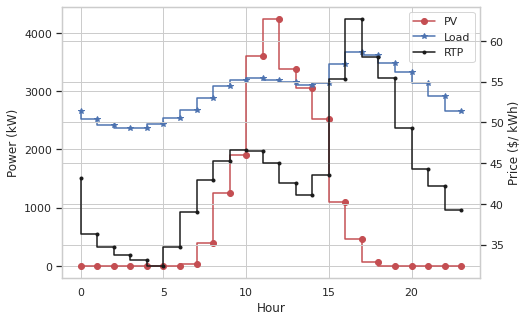

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,5))
ax2 = ax.twinx()
PV_plot = ax.step(np.arange(24), df.iloc[0:24,0], 'ro-', label = "PV")
load_plot = ax.step(np.arange(24), df.iloc[0:24,1], 'b*-', label = "Load")
price_plot = ax2.step(np.arange(24), df.iloc[0:24,2], 'k.-', label = "RTP")

# Display all label in one box
plots = PV_plot + load_plot + price_plot
labels = [plot.get_label() for plot in plots]
ax.legend(plots, labels, loc = 0)
ax.set_xlabel("Hour")
ax.set_ylabel("Power (kW)")
ax2.set_ylabel("Price ($/ kWh)")

plt.show()

### **Normalization**

In [6]:
# MinMaxScaler = StandardScaler(with_mean = False)

# The mean is not shifted to zero-centered
sc_price = StandardScaler(with_mean=False)
price = sc_price.fit_transform(df.iloc[:,2:3].values)

sc_energy = StandardScaler(with_mean=False)
pv = sc_energy.fit_transform(df.iloc[:,0:1].values)
load = sc_energy.transform(df.iloc[:,1:2].values)

x = np.concatenate([pv, load, price], axis = -1)

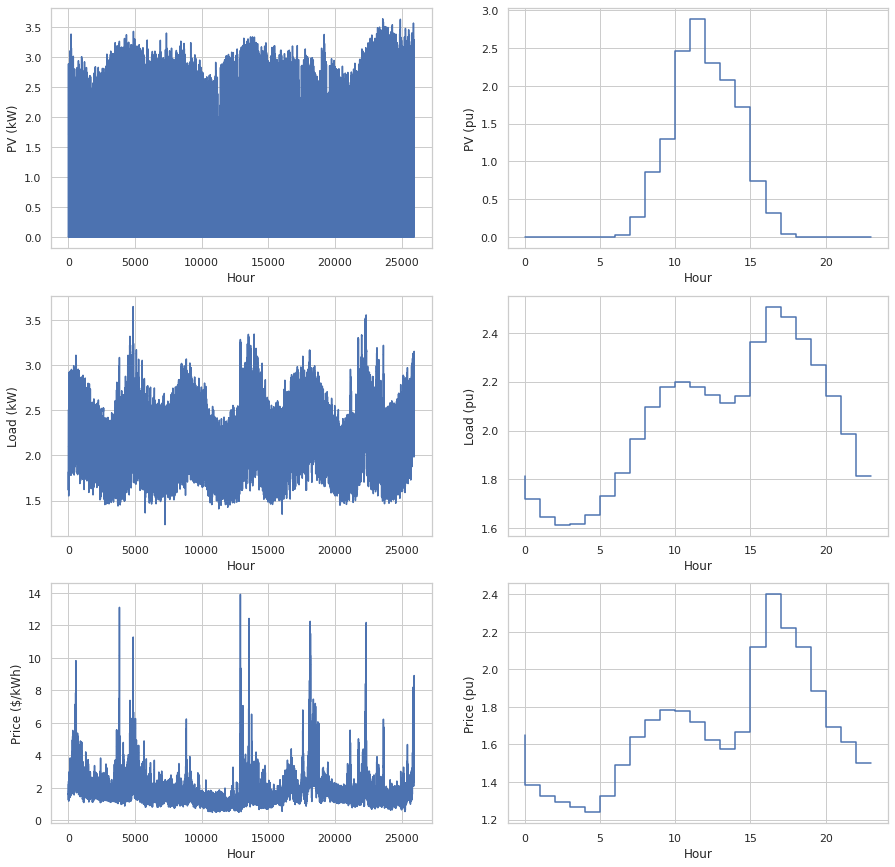

In [7]:
fig, ax = plt.subplots(3, 2, figsize = (15, 15))

ax[0, 0].step(np.arange(len(x[:,0])), x[:,0])
ax[0, 0].set_xlabel("Hour")
ax[0, 0].set_ylabel("PV (kW)")
ax[0, 1].step(np.arange(len(x[0:24,0])), x[0:24,0])
ax[0, 1].set_xlabel("Hour")
ax[0, 1].set_ylabel("PV (pu)")

ax[1, 0].step(np.arange(len(x[:,1])), x[:,1])
ax[1, 0].set_xlabel("Hour")
ax[1, 0].set_ylabel("Load (kW)")
ax[1, 1].step(np.arange(len(x[0:24,1])), x[0:24,1])
ax[1, 1].set_xlabel("Hour")
ax[1, 1].set_ylabel("Load (pu)")

ax[2, 0].step(np.arange(len(x[:,2])), x[:,2])
ax[2, 0].set_xlabel("Hour")
ax[2, 0].set_ylabel("Price ($/kWh)")
ax[2, 1].step(np.arange(len(x[0:24,2])), x[0:24,2])
ax[2, 1].set_xlabel("Hour")
ax[2, 1].set_ylabel("Price (pu)")

plt.show()

### **Train test split & generate sequential data**

In [8]:
def get_sequential_data(timesteps_in, timesteps_out, serial_data, feature_data):

  x, x2, y, y2 = [], [], [], []
  for i in range (timesteps_in, len(serial_data)-timesteps_out+1, 1):
    x.append(serial_data[i-timesteps_in:i])
    x2.append(feature_data[i-timesteps_in:i])
    y.append(serial_data[i:i+timesteps_out])
    y2.append(feature_data[i:i+timesteps_out])

  # Samples, timestep, features
  x, x2, y, y2 = np.array(x), np.array(x2), np.array(y), np.array(y2)
  x = np.expand_dims(x, axis=-1)
  y = np.expand_dims(y, axis=-1)
  x = np.concatenate((x, x2), axis=-1)
  y = np.concatenate((y, y2), axis=-1)

  return x, y

In [9]:
def get_split_data(timesteps_in, timesteps_out, sequential_data, feature_data):

  x, y =  get_sequential_data(timesteps_in, timesteps_out, sequential_data, feature_data)
  x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42)
  x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5, shuffle=True, random_state=42)

  return x_train, x_valid, x_test, y_train, y_valid, y_test

In [10]:
# 2 weeks of lagged observation to predict next 24 hours
timesteps_in = 2 * 7 * 24
timesteps_out = 24

# 3 items to be predicted
items = ["PV", "Load", "Price"]

# **Prediction**



In [11]:
"""
1. The dataset is split into training, validation and testing set.
2. For each sample in the dataset, there are 41 features, load and one-hot 
   encoded months, weekdays of the week and hours of the day, of two weeks 
   (the previous 336-hour) prior to the target prediction period (the next 24-hour).
3. The shape of the set - (# samples, # timesteps, # features) = (# samples, 336, 41)
"""

item_no = 0
x_train, x_valid, x_test, y_train, y_valid, y_test =  get_split_data(timesteps_in,
                                                                     timesteps_out, 
                                                                     x[:, item_no], 
                                                                     df.iloc[:, 12:].values)

In [12]:
directory = "/content/drive/My Drive/Colab/Research - EE5003/Phase 1 - Comparison of forecasting technique/PV - Model Weights/"

### **LSTM**



In [13]:
from lstm import lstm_model
from sklearn.metrics import mean_absolute_error as mae

In [14]:
"""
1. The shape of the model input - (# samples, # timesteps, # features) = (# samples, 336, 41)
2. The shape of the model output - (# samples, # timesteps) = (# samples, 24)
"""

lstm_units = 32
num_features = y_train.shape[2]

lstm = lstm_model(lstm_units, timesteps_in, timesteps_out, num_features, directory)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 336, 41)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 336, 32)           9472      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 24)                792       
Total params: 18,584
Trainable params: 18,584
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm.fit_model(x_train[:, :, :], y_train[:, :, 0], x_valid[:, :, :], y_valid[:, :, 0])

Epoch 1/20
280/280 [==============================] - 9s 34ms/step - loss: 0.1802 - val_loss: 0.1791
Epoch 2/20
280/280 [==============================] - 10s 34ms/step - loss: 0.1784 - val_loss: 0.1825
Epoch 3/20
280/280 [==============================] - 9s 34ms/step - loss: 0.1775 - val_loss: 0.1810
Epoch 4/20
280/280 [==============================] - 9s 33ms/step - loss: 0.1775 - val_loss: 0.1758
Epoch 5/20
280/280 [==============================] - 9s 34ms/step - loss: 0.1740 - val_loss: 0.1793
Epoch 6/20
280/280 [==============================] - 9s 34ms/step - loss: 0.1735 - val_loss: 0.1738
Epoch 7/20
280/280 [==============================] - 9s 33ms/step - loss: 0.1740 - val_loss: 0.1757
Epoch 8/20
280/280 [==============================] - 9s 33ms/step - loss: 0.1697 - val_loss: 0.1743
Epoch 9/20
280/280 [==============================] - 9s 33ms/step - loss: 0.1689 - val_loss: 0.1705
Epoch 10/20
280/280 [==============================] - 9s 33ms/step - loss: 0.1730 - val_l

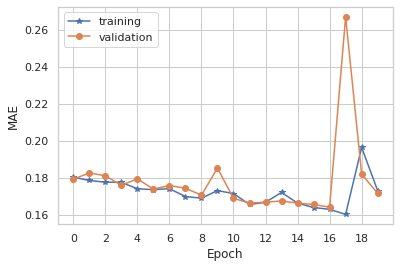

In [ ]:
plt.plot(lstm.history.history["loss"], "-*", label="training")
plt.plot(lstm.history.history["val_loss"], "-o", label="validation")
plt.xticks(np.arange(0, 20, 2), np.arange(0, 20, 2))
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

Testing MAE: 0.1607 pu



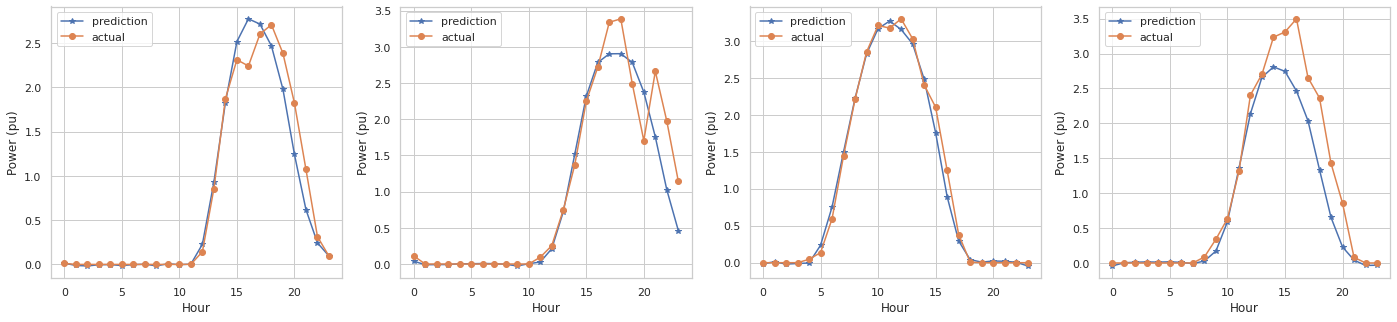

In [15]:
y_train_pred = lstm.predict(x_train[:, :, :])

print ("Testing MAE: {:.4f} pu\n".format(mae(y_train[:, :, 0], y_train_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_train_pred[i], "-*", label="prediction")
  ax.plot(y_train[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 0.1675 pu



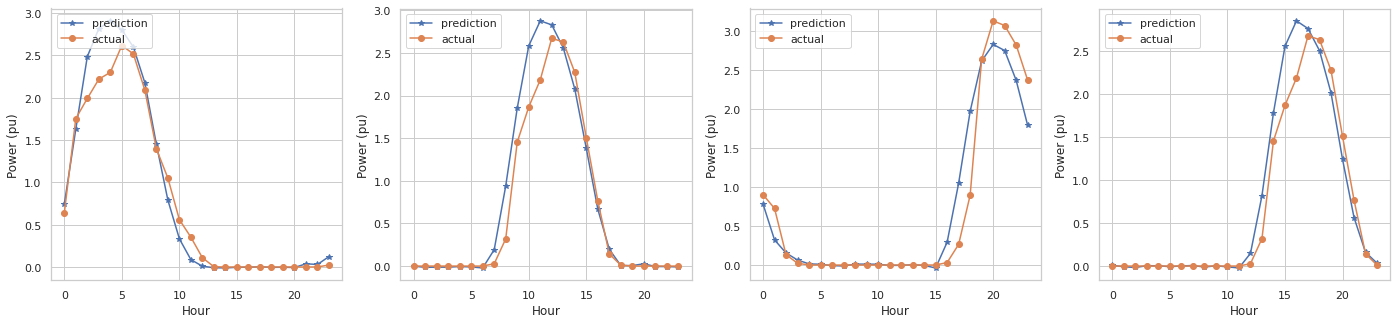

In [16]:
y_test_pred = lstm.predict(x_test[:, :, :])

print ("Testing MAE: {:.4f} pu\n".format(mae(y_test[:, :, 0], y_test_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_test_pred[i], "-*", label="prediction")
  ax.plot(y_test[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 236.0522 W



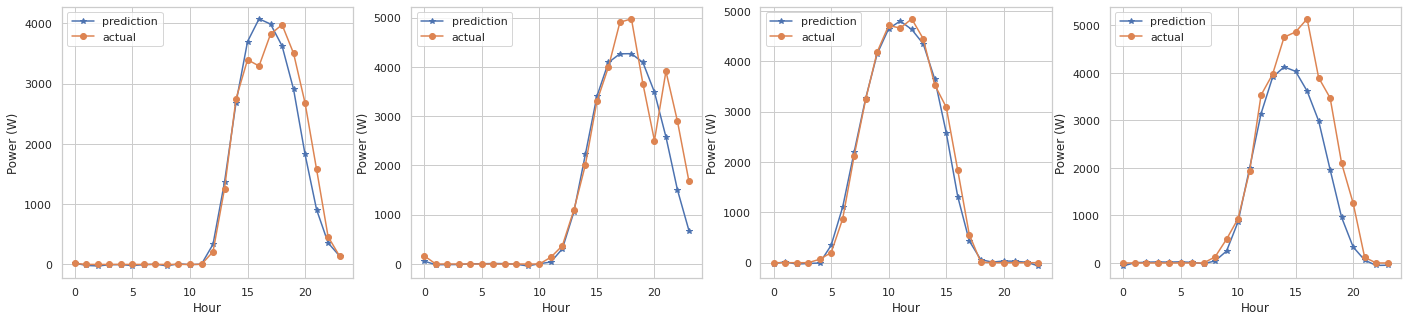

In [17]:
inverse_y_train_pred = sc_energy.inverse_transform(y_train_pred)
inverse_y_train = sc_energy.inverse_transform(y_train[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_train, inverse_y_train_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_train_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_train[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 245.9793 W



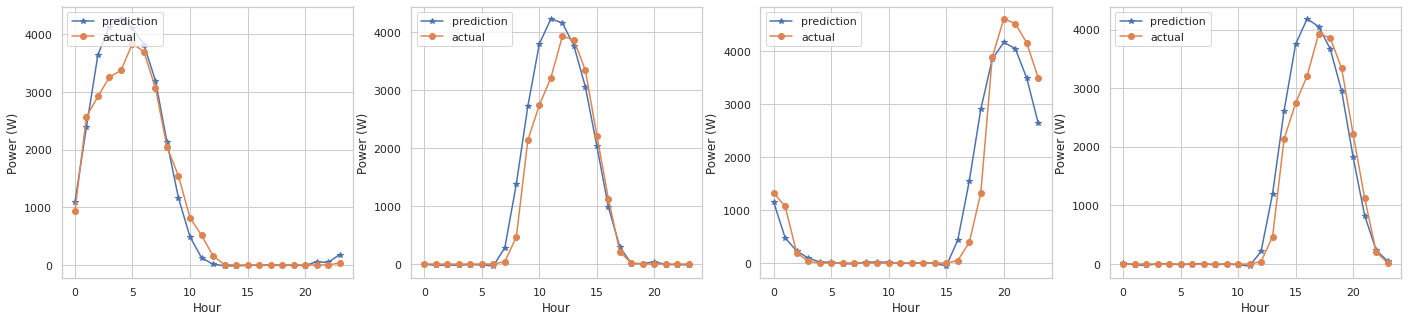

In [18]:
inverse_y_test_pred = sc_energy.inverse_transform(y_test_pred)
inverse_y_test = sc_energy.inverse_transform(y_test[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_test, inverse_y_test_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_test_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_test[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

### **Seq2Seq**

In [19]:
from seq2seq import seq2seq_model
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
"""
1. The shape of the model input - (# samples, # timesteps, # features) = (# samples, 336, 41)
2. The shape of the model output - (# samples, # timesteps) = (# samples, 24)
"""

encoder_units = 32
decoder_units = 32
num_features = 41

seq2seq = seq2seq_model(encoder_units, decoder_units, timesteps_in, timesteps_out, num_features, directory)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 336, 41)]    0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 32), (None,  9472        input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 24, 32)       0           lstm_2[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 24, 32)       8320        repeat_vector[0][0]              
                                                                 lstm_2[0][1]               

In [ ]:
seq2seq.fit_model(x_train, y_train[:, :, 0:1], x_valid, y_valid[:, :, 0:1])

Epoch 1/20
280/280 [==============================] - 6s 20ms/step - loss: 0.1714 - val_loss: 0.1755
Epoch 2/20
280/280 [==============================] - 6s 20ms/step - loss: 0.1697 - val_loss: 0.1723
Epoch 3/20
280/280 [==============================] - 6s 20ms/step - loss: 0.1669 - val_loss: 0.1681
Epoch 4/20
280/280 [==============================] - 6s 20ms/step - loss: 0.1646 - val_loss: 0.1657
Epoch 5/20
280/280 [==============================] - 6s 21ms/step - loss: 0.1635 - val_loss: 0.1618
Epoch 6/20
280/280 [==============================] - 6s 20ms/step - loss: 0.1647 - val_loss: 0.1628
Epoch 7/20
280/280 [==============================] - 6s 20ms/step - loss: 0.1591 - val_loss: 0.1601
Epoch 8/20
280/280 [==============================] - 6s 20ms/step - loss: 0.1580 - val_loss: 0.1628
Epoch 9/20
280/280 [==============================] - 6s 20ms/step - loss: 0.1559 - val_loss: 0.1591
Epoch 10/20
280/280 [==============================] - 6s 20ms/step - loss: 0.1543 - val_lo

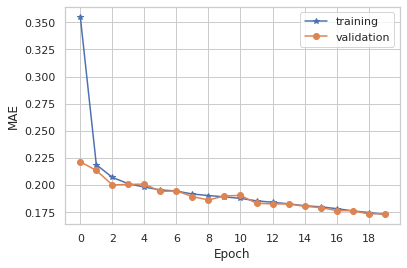

In [ ]:
plt.plot(seq2seq.history.history["loss"], "-*", label="training")
plt.plot(seq2seq.history.history["val_loss"], "-o", label="validation")
plt.xticks(np.arange(0, 20, 2), np.arange(0, 20, 2))
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

Testing MAE: 0.1409 pu



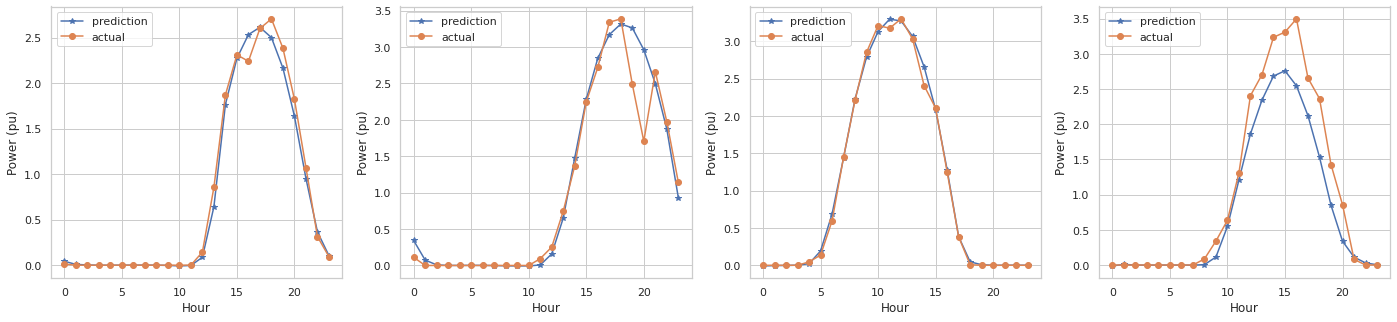

In [21]:
y_train_pred = seq2seq.predict(x_train[:, :, :])

print ("Testing MAE: {:.4f} pu\n".format(mae(y_train[:, :, 0], y_train_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_train_pred[i], "-*", label="prediction")
  ax.plot(y_train[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 0.1488 pu



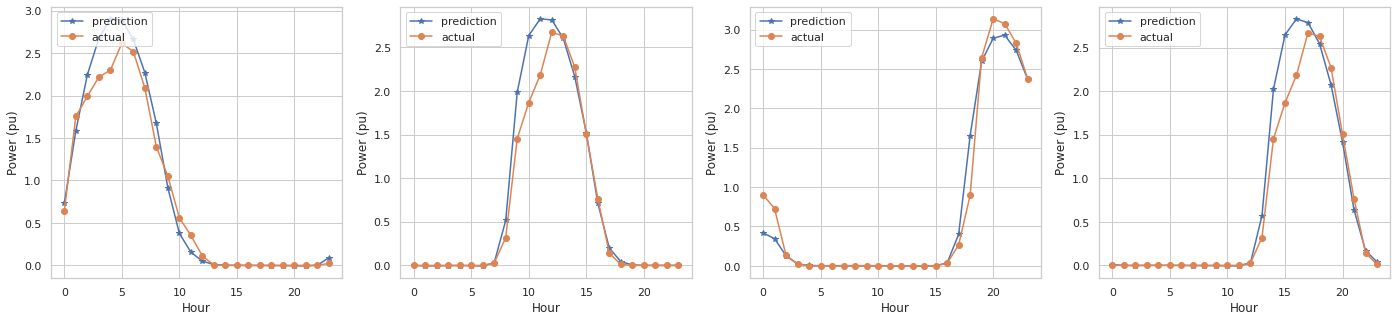

In [22]:
y_test_pred = seq2seq.predict(x_test[:, :, :])

print ("Testing MAE: {:.4f} pu\n".format(mae(y_test[:, :, 0], y_test_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_test_pred[i], "-*", label="prediction")
  ax.plot(y_test[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 207.0186 W



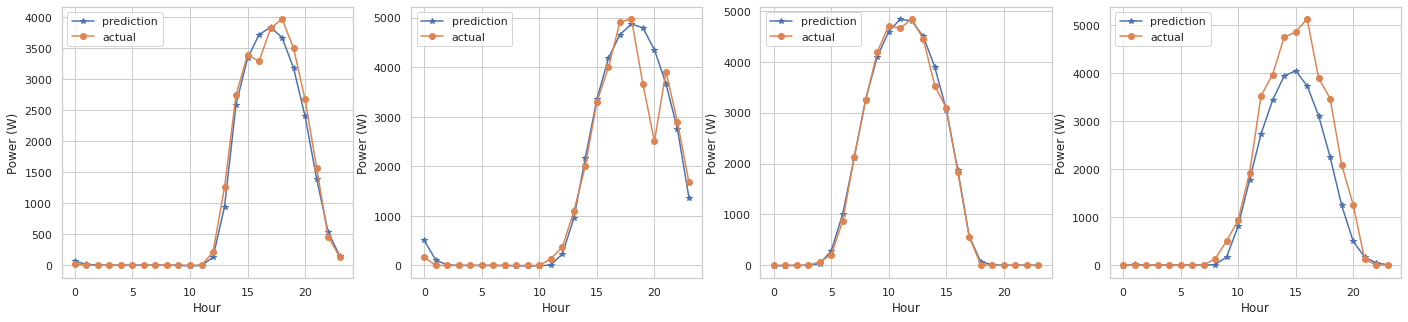

In [23]:
inverse_y_train_pred = sc_energy.inverse_transform(y_train_pred[:, :, 0])
inverse_y_train = sc_energy.inverse_transform(y_train[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_train, inverse_y_train_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_train_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_train[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 218.6355 W



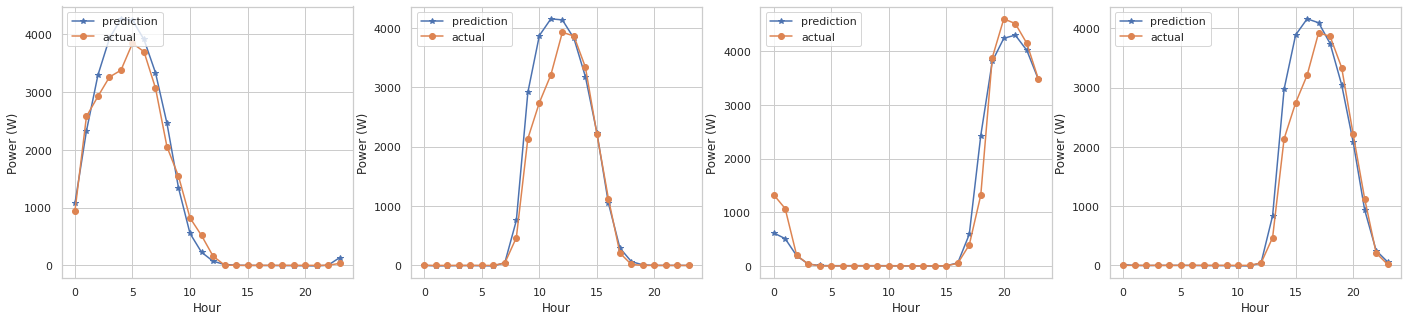

In [24]:
inverse_y_test_pred = sc_energy.inverse_transform(y_test_pred[:, :, 0])
inverse_y_test = sc_energy.inverse_transform(y_test[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_test, inverse_y_test_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_test_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_test[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

### **Seq2Seq (Attention)**

In [25]:
from seq2seqatt import Encoder, Decoder
from sklearn.metrics import mean_absolute_error as mae

In [26]:
def loss_function(real, pred):
  loss = tf.keras.losses.MAE(real, pred)
  return tf.reduce_mean(loss) # mean of each sample

In [27]:
def get_batch(inps, tars, batch_size):
    l = len(inps)
    for i in range(0, l, batch_size):
        yield i / batch_size, inps[i:min(i + batch_size, l)], tars[i:min(i + batch_size, l)]

In [28]:
def predict(x_test, y_test):

  inps = x_test.astype(np.float32)
  tars = y_test[:, :, :].astype(np.float32)

  for batch, inp, tar in get_batch(inps, tars, batch_size):
    state_h, state_c = encoder.initialize_state()

    # adjust to suit the current batch size
    state_h, state_c = state_h[:len(inp), :], state_c[:len(inp), :]
    enc_output, state_h, state_c = encoder(inp, state_h, state_c)

    # Use teacher forcing - feed the actual input of the former step for next step prediction
    # Use the feature data of the next step
    dec_input = inp[:, -1:, :] # 41 features input
      
    for t in range(0, timesteps_out):
      predictions, attention_weights, state_h, state_c = decoder(dec_input, enc_output, state_h, state_c)
      dec_input = tf.concat((predictions, tar[:, t:t+1, 1:]), axis=-1) # 41 features input

      if t == 0:
        outputs = predictions
        batch_attentions = attention_weights
      else:
        outputs = tf.concat([outputs, predictions], axis=1)
        batch_attentions = tf.concat([batch_attentions, attention_weights], axis=2)

    if batch == 0:
      y_test_pred = outputs
      attentions = batch_attentions
    else:
      y_test_pred = tf.concat([y_test_pred, outputs], axis=0)
      attentions = tf.concat([attentions, batch_attentions], axis=0)

  return y_test_pred, attentions

In [29]:
def plot_graph(inp, pred, att):

  fig = plt.figure(figsize=(24,8))
  spec = gridspec.GridSpec(ncols=90, nrows=100)

  top_ax = fig.add_subplot(spec[0:15, 7:73])
  left_ax = fig.add_subplot(spec[25:, 0:5])
  right_ax = fig.add_subplot(spec[25:, 7:])

  top_ax.plot(inp)
  top_ax.set_xlim([0, timesteps_in])
  top_ax.set_xticks(range(0, timesteps_in, 8))
  top_ax.set_xticklabels(range(0, timesteps_in, 8))

  left_ax.plot(pred, range(0, timesteps_out))
  left_ax.set_yticks(range(0, timesteps_out, 2))
  left_ax.set_yticklabels(range(0, timesteps_out, 2))
  left_ax.invert_yaxis()

  sns.heatmap(tf.transpose(att), cmap="viridis", ax=right_ax)
  right_ax.set_xticks(range(0, timesteps_in, 8))
  right_ax.set_xticklabels(range(0, timesteps_in, 8))
  right_ax.set_yticks(range(0, timesteps_out, 2))
  right_ax.set_yticklabels(range(0, timesteps_out, 2))

  plt.show()

In [30]:
"""
1. The shape of the encoder input - (# samples, # timesteps, # features) = (# samples, 336, 41)
2. The shape of the decoder input - (# samples, 1, # features) = (# samples, 1, 41)
3. Feed the features of the previous timestep for the prediction of current timestep
4. No teacher forcing is used - better result achieved
"""

# Model parameters
encoder_units = 32
decoder_units = 32
conv1d_units = 16

# Training parameters
optimizer = tf.keras.optimizers.Adam(0.0001)
epochs = 30
batch_size = 128
val_loss_bef = np.inf

encoder = Encoder(encoder_units, conv1d_units, batch_size, directory)
decoder = Decoder(decoder_units, conv1d_units, directory)

In [ ]:
inps = x_train.astype(np.float32)
tars = y_train[:, :, :].astype(np.float32)

for epoch in range(epochs):
  start = time.time()
  train_loss = 0

  for batch, inp, tar in get_batch(inps, tars, batch_size):
    loss = 0
    state_h, state_c = encoder.initialize_state()
    
    with tf.GradientTape() as tape:
      # Adjust to suit the current batch size
      state_h, state_c = state_h[:len(inp), :], state_c[:len(inp), :]
      enc_output, state_h, state_c = encoder(inp, state_h, state_c)

      # Use teacher forcing - feed the actual input of the former step for next step prediction
      # Use the feature data of the next step
      dec_input = inp[:, -1:, :] # 41 features input
      
      # Use teacher forcing - feed the actual input of the former step for next step prediction
      for t in range(0, timesteps_out):
        #print (t, dec_input.shape)
        predictions, _, state_h, state_c = decoder(dec_input, enc_output, state_h, state_c)
        loss += loss_function(tar[:, t:t+1, 0:1], predictions)
        dec_input = tar[:, t:t+1, :] # 41 features input
  
    train_loss += (loss / timesteps_out)
    
    # Training with the loss 
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)   
    optimizer.apply_gradients(zip(gradients, variables))
  
  y_valid_pred, _ = predict(x_valid, y_valid)
  val_loss = mae(y_valid[:, :, 0], y_valid_pred[:, :, 0])
  
  # Save the weights of best model
  if val_loss < val_loss_bef:
    encoder.save_weights(encoder.weights_dir)
    decoder.save_weights(decoder.weights_dir)
    val_loss_bef = val_loss

  print('Epoch {} training loss - {:.4f}, validation loss - {:.4f}'.format(epoch + 1, train_loss / (batch + 1), val_loss))
  print('Best validation loss - {:.4f}, time taken for 1 epoch {:.4f} sec\n'.format(val_loss_bef, time.time() - start))

Epoch 1 training loss - 0.5964, validation loss - 0.6013
Best validation loss - 0.6013, time taken for 1 epoch 48.4634 sec

Epoch 2 training loss - 0.4554, validation loss - 0.4849
Best validation loss - 0.4849, time taken for 1 epoch 47.7231 sec

Epoch 3 training loss - 0.3168, validation loss - 0.3454
Best validation loss - 0.3454, time taken for 1 epoch 48.1510 sec

Epoch 4 training loss - 0.2309, validation loss - 0.2898
Best validation loss - 0.2898, time taken for 1 epoch 48.3141 sec

Epoch 5 training loss - 0.1996, validation loss - 0.2703
Best validation loss - 0.2703, time taken for 1 epoch 47.9172 sec

Epoch 6 training loss - 0.1824, validation loss - 0.2598
Best validation loss - 0.2598, time taken for 1 epoch 48.2675 sec

Epoch 7 training loss - 0.1708, validation loss - 0.2532
Best validation loss - 0.2532, time taken for 1 epoch 48.6953 sec

Epoch 8 training loss - 0.1627, validation loss - 0.2484
Best validation loss - 0.2484, time taken for 1 epoch 48.0420 sec

Epoch 9 

Training MAE: 0.2343 pu



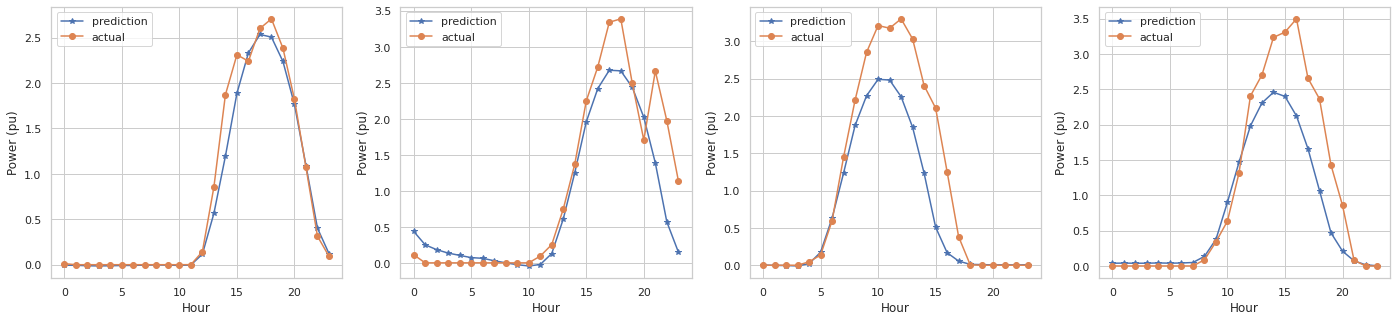

In [31]:
encoder.load_weights(encoder.weights_dir)
decoder.load_weights(decoder.weights_dir)

y_train_pred, attentions = predict(x_train, y_train)
print ("Training MAE: {:.4f} pu\n".format(mae(y_train[:, :, 0], y_train_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_train_pred[i], "-*", label="prediction")
  ax.plot(y_train[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

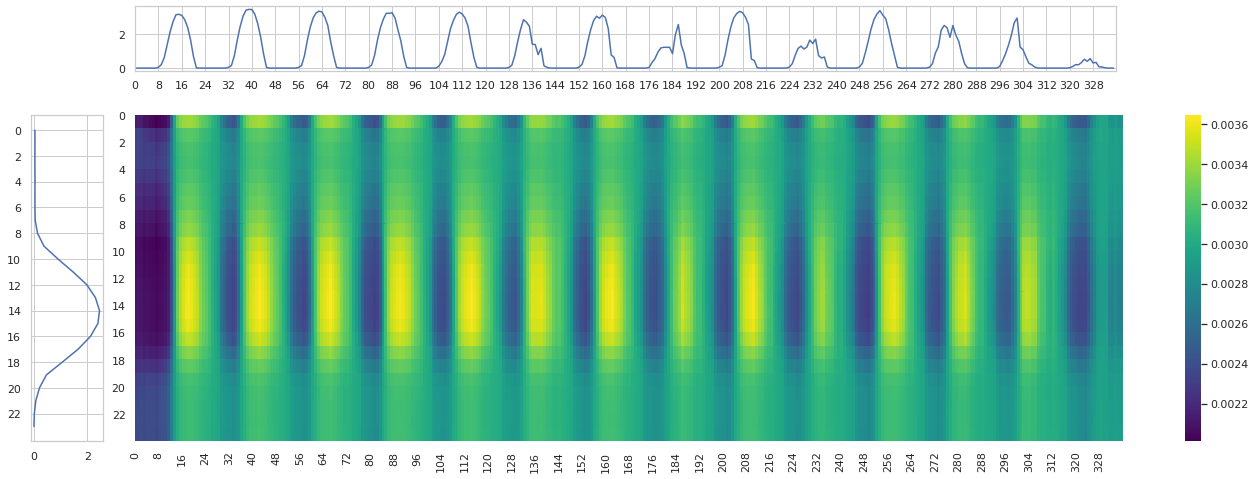

In [32]:
idx = 3000
inp = x_train[idx, :, 0]
pred = y_train_pred[idx, :, 0]
att = attentions[idx]

plot_graph(inp, pred, att)

Testing MAE: 0.2351 pu



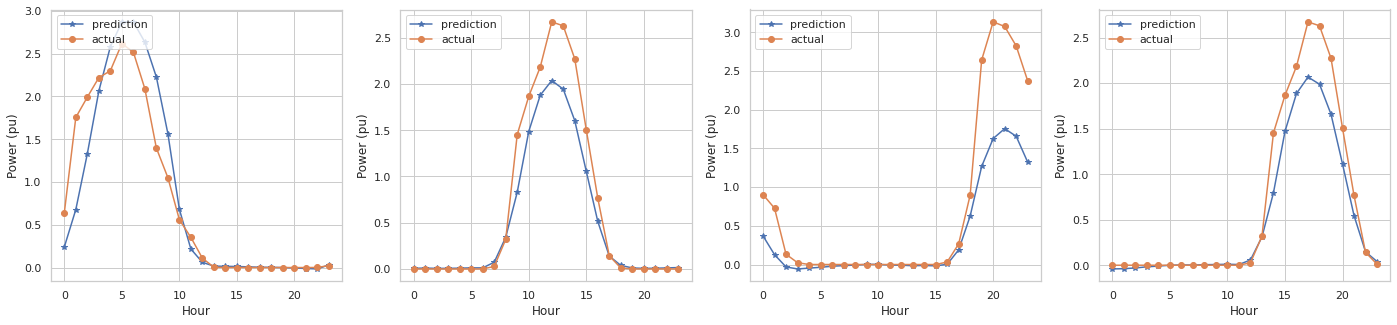

In [33]:
encoder.load_weights(encoder.weights_dir)
decoder.load_weights(decoder.weights_dir)

y_test_pred, attentions = predict(x_test, y_test)
print ("Testing MAE: {:.4f} pu\n".format(mae(y_test[:, :, 0], y_test_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_test_pred[i], "-*", label="prediction")
  ax.plot(y_test[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Training MAE: 344.1275 W



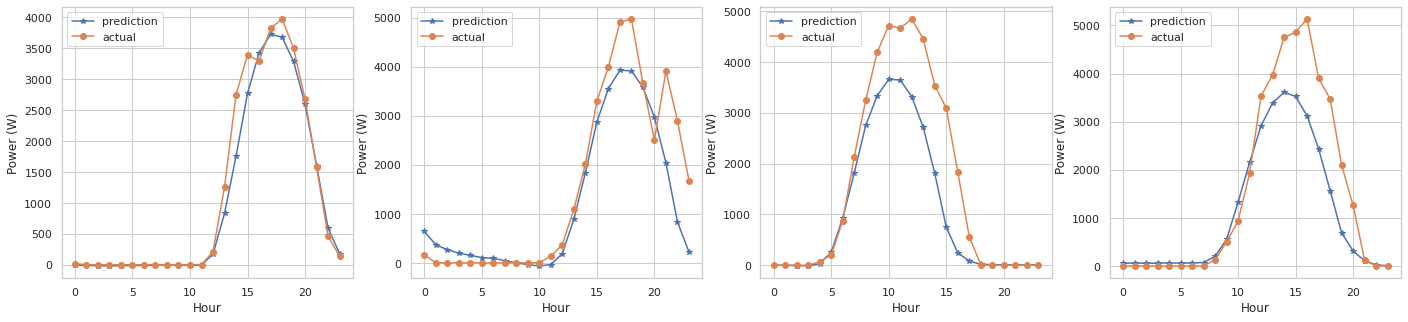

In [34]:
inverse_y_train_pred = sc_energy.inverse_transform(y_train_pred[:, :, 0])
inverse_y_train = sc_energy.inverse_transform(y_train[:, :, 0]) 

print ("Training MAE: {:.4f} W\n".format(mae(inverse_y_train, inverse_y_train_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_train_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_train[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 345.3457 W



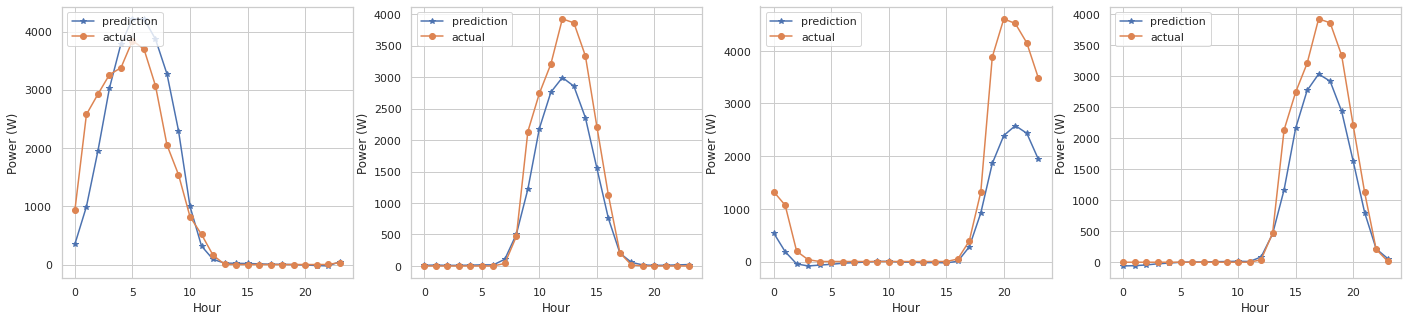

In [35]:
inverse_y_test_pred = sc_energy.inverse_transform(y_test_pred[:, :, 0])
inverse_y_test = sc_energy.inverse_transform(y_test[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_test, inverse_y_test_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_test_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_test[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

### **Transformer with kernel of length 5**

In [36]:
from tx import tx_model
from sklearn.metrics import mean_absolute_error as mae

In [37]:
"""
1. The shape of the encoder input - (# samples, # timesteps, # features) = (# samples, 336, 41) (the past 336 hours)
2. The shape of the decoder input - (# samples, 24, # features) = (# samples, 24, 41) (the past 24 hours)
"""

# user defined transformer parameters
num_layers = 1
d_model = 64
num_heads = 4
dff = 64
kernel_size = 5
dropout_rate = 0.1

tx = tx_model(num_layers, d_model, num_heads, dff,
              kernel_size, dropout_rate, timesteps_in, 
              timesteps_out, items[item_no], directory)

In [ ]:
tx.fit_model(x_train[:, :, :], y_train[:, :, :], x_valid[:, :, :], y_valid[:, :, :])

Epoch 1 training loss - 0.2398, validation loss - 0.2363
Best validation loss - 0.2363, time taken for 1 epoch 24.8962 sec

Epoch 2 training loss - 0.2377, validation loss - 0.2294
Best validation loss - 0.2294, time taken for 1 epoch 24.8428 sec

Epoch 3 training loss - 0.2341, validation loss - 0.2234
Best validation loss - 0.2234, time taken for 1 epoch 24.9820 sec

Epoch 4 training loss - 0.2318, validation loss - 0.2244
Best validation loss - 0.2234, time taken for 1 epoch 24.7821 sec

Epoch 5 training loss - 0.2286, validation loss - 0.2195
Best validation loss - 0.2195, time taken for 1 epoch 24.9612 sec

Epoch 6 training loss - 0.2259, validation loss - 0.2185
Best validation loss - 0.2185, time taken for 1 epoch 24.7125 sec

Epoch 7 training loss - 0.2231, validation loss - 0.2135
Best validation loss - 0.2135, time taken for 1 epoch 24.8856 sec

Epoch 8 training loss - 0.2196, validation loss - 0.2028
Best validation loss - 0.2028, time taken for 1 epoch 25.0992 sec

Epoch 9 

In [ ]:
tx.fit_model(x_train[:, :, :], y_train[:, :, :], x_valid[:, :, :], y_valid[:, :, :])

In [ ]:
tx.model.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  71168     
_________________________________________________________________
decoder_2 (Decoder)          multiple                  120704    
_________________________________________________________________
dense_22 (Dense)             multiple                  65        
Total params: 191,937
Trainable params: 191,937
Non-trainable params: 0
_________________________________________________________________


Testing MAE: 0.1909 pu



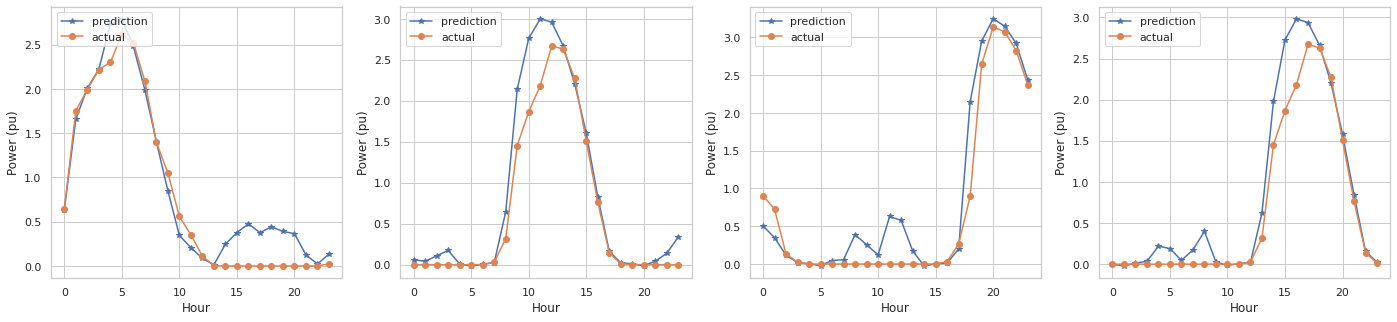

In [38]:
# attention_weights are saved for the last batch only
y_test_pred, attention_weights, decoder_input = tx.predict(x_test[:, :, :], False)

print ("Testing MAE: {:.4f} pu\n".format(mae(y_test[:, :, 0], y_test_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_test_pred[i], "-*", label="prediction")
  ax.plot(y_test[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Training MAE: 0.1881 pu



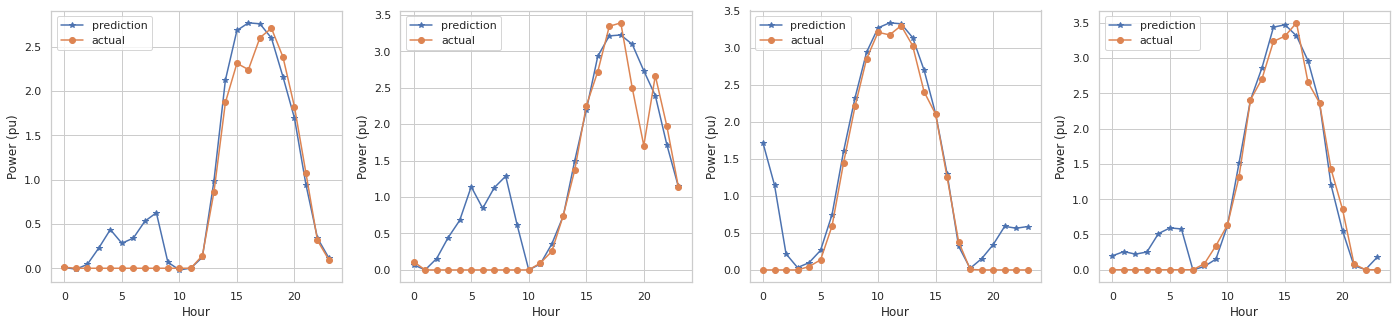

In [39]:
# attention_weights are saved for the last batch only
y_train_pred, attention_weights, decoder_input = tx.predict(x_train[:, :, :], False)

print ("Training MAE: {:.4f} pu\n".format(mae(y_train[:, :, 0], y_train_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_train_pred[i], "-*", label="prediction")
  ax.plot(y_train[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Training MAE: 276.2664 W



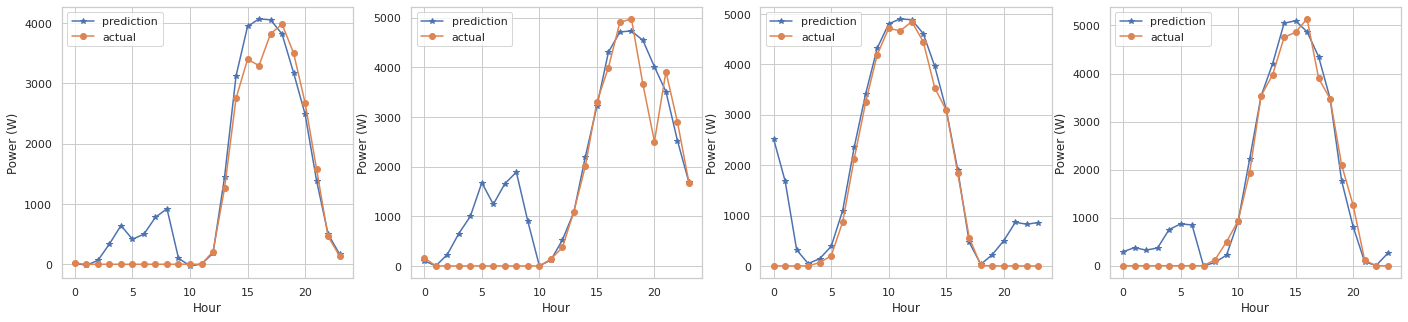

In [40]:
inverse_y_train_pred = sc_energy.inverse_transform(y_train_pred[:, :, 0])
inverse_y_train = sc_energy.inverse_transform(y_train[:, :, 0]) 

print ("Training MAE: {:.4f} W\n".format(mae(inverse_y_train, inverse_y_train_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_train_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_train[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 280.3530 W



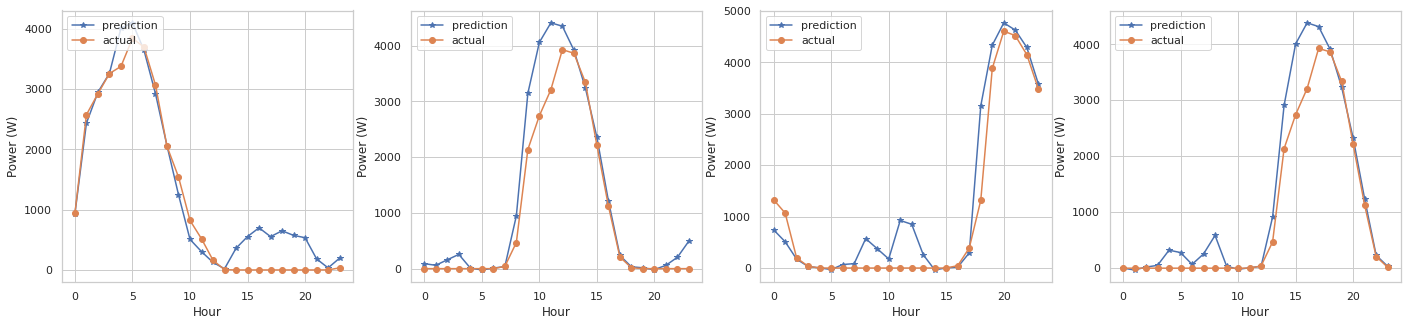

In [41]:
inverse_y_test_pred = sc_energy.inverse_transform(y_test_pred[:, :, 0])
inverse_y_test = sc_energy.inverse_transform(y_test[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_test, inverse_y_test_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_test_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_test[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

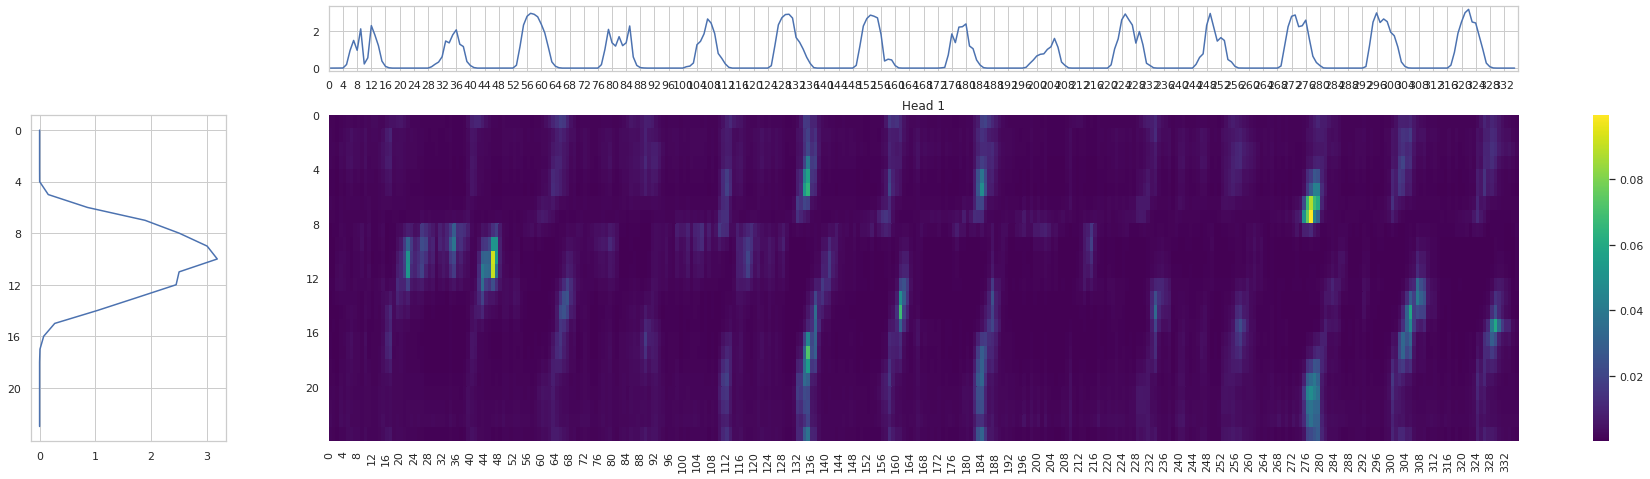

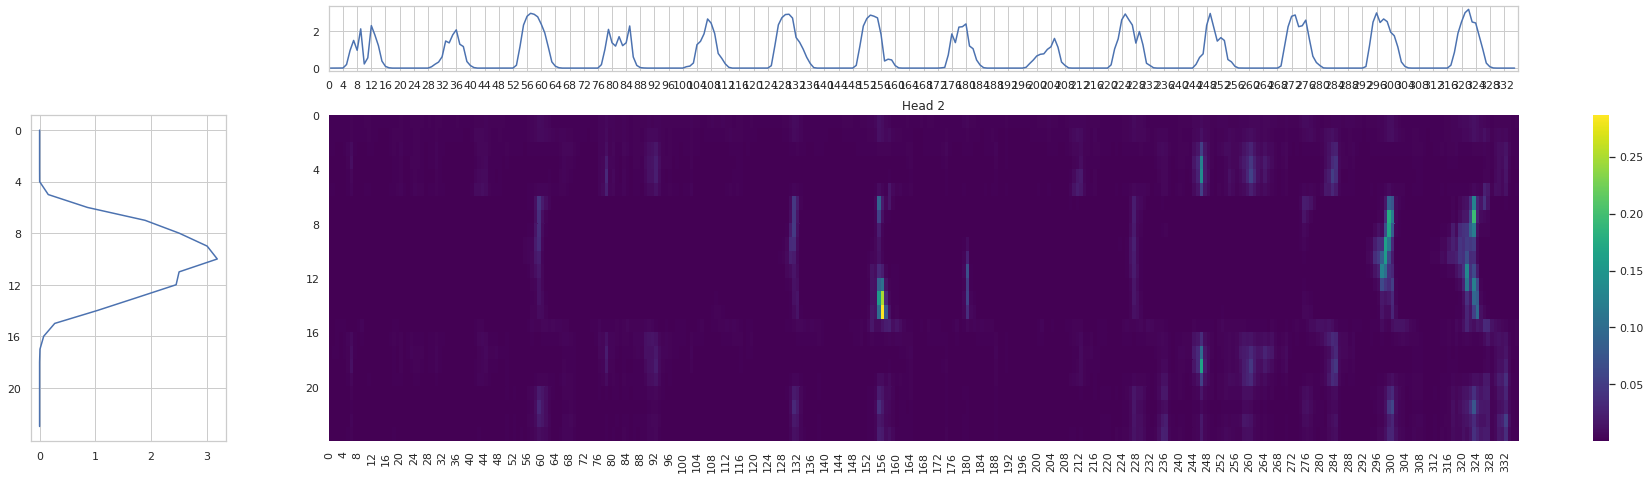

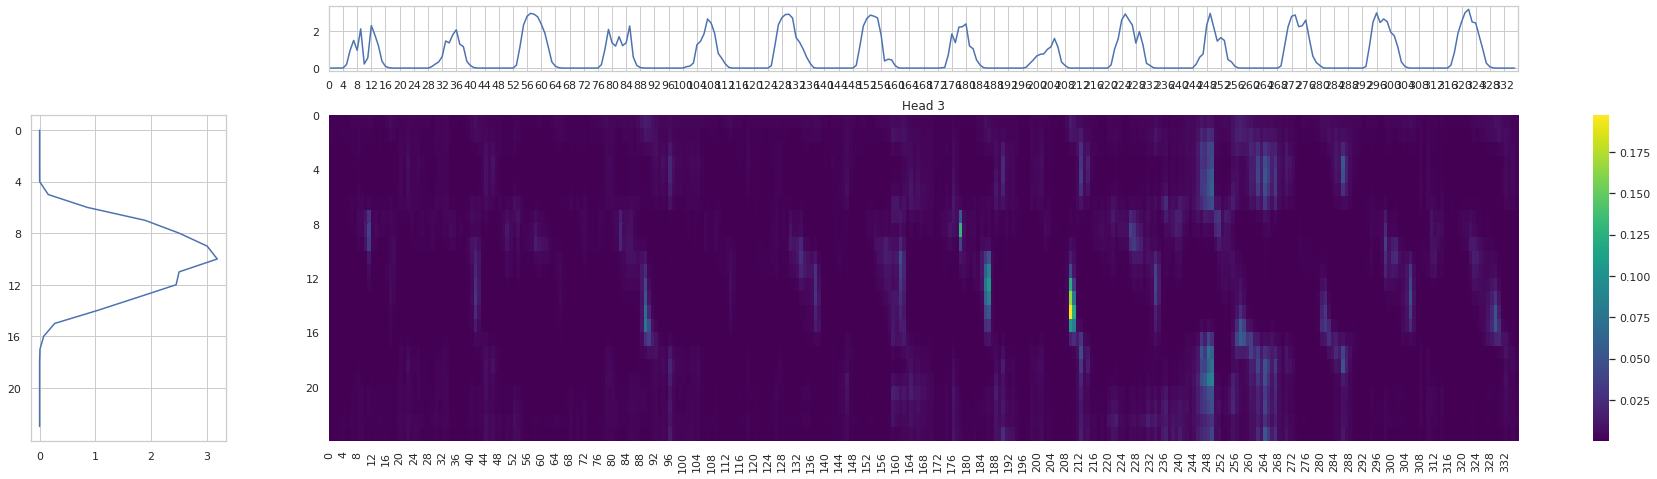

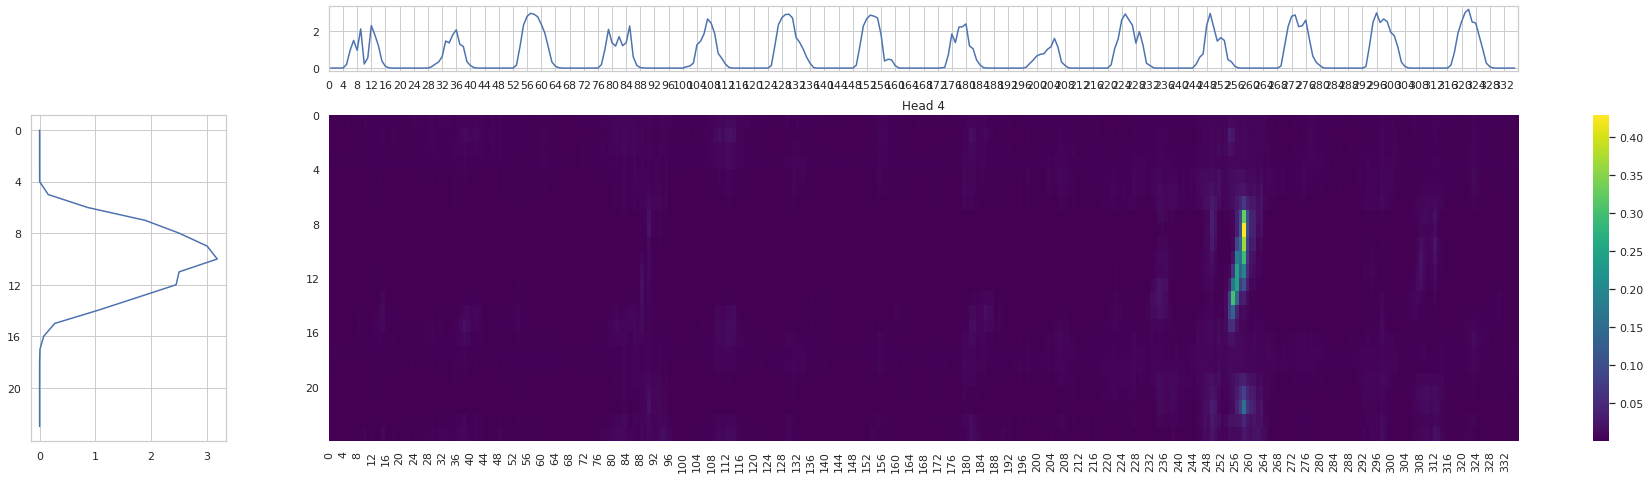

In [ ]:
idx = -10

num_steps_display = timesteps_in

attention = attention_weights
attention = tf.squeeze(attention["decoder_layer1_block2"][idx:idx+1], axis=0)

for head in range(0, num_heads):
  fig = plt.figure(figsize=(32,8))
  spec = gridspec.GridSpec(ncols=90, nrows=100)
  
  top_ax = fig.add_subplot(spec[0:15, 15:75])
  left_ax = fig.add_subplot(spec[25:, 0:10])
  right_ax = fig.add_subplot(spec[25:, 15:])
  
  top_ax.plot(x_train[idx, :num_steps_display, 0])
  top_ax.set_xlim([0, num_steps_display])
  top_ax.set_xticks(range(0, num_steps_display, 4))
  top_ax.set_xticklabels(range(0, num_steps_display, 4))

  left_ax.plot(decoder_input[idx, :, 0], range(0, timesteps_out))
  left_ax.set_yticks(range(0, timesteps_out, 4))
  left_ax.set_yticklabels(range(0, timesteps_out, 4))
  left_ax.invert_yaxis()

  sns.heatmap(attention[head][:, :num_steps_display], cmap="viridis", ax=right_ax)
  right_ax.set_xticks(range(0, num_steps_display, 4))
  right_ax.set_xticklabels(range(0, num_steps_display, 4))
  right_ax.set_yticks(range(0, timesteps_out, 4))
  right_ax.set_yticklabels(range(0, timesteps_out, 4))

  plt.title("Head {}".format(head+1))
  plt.show()

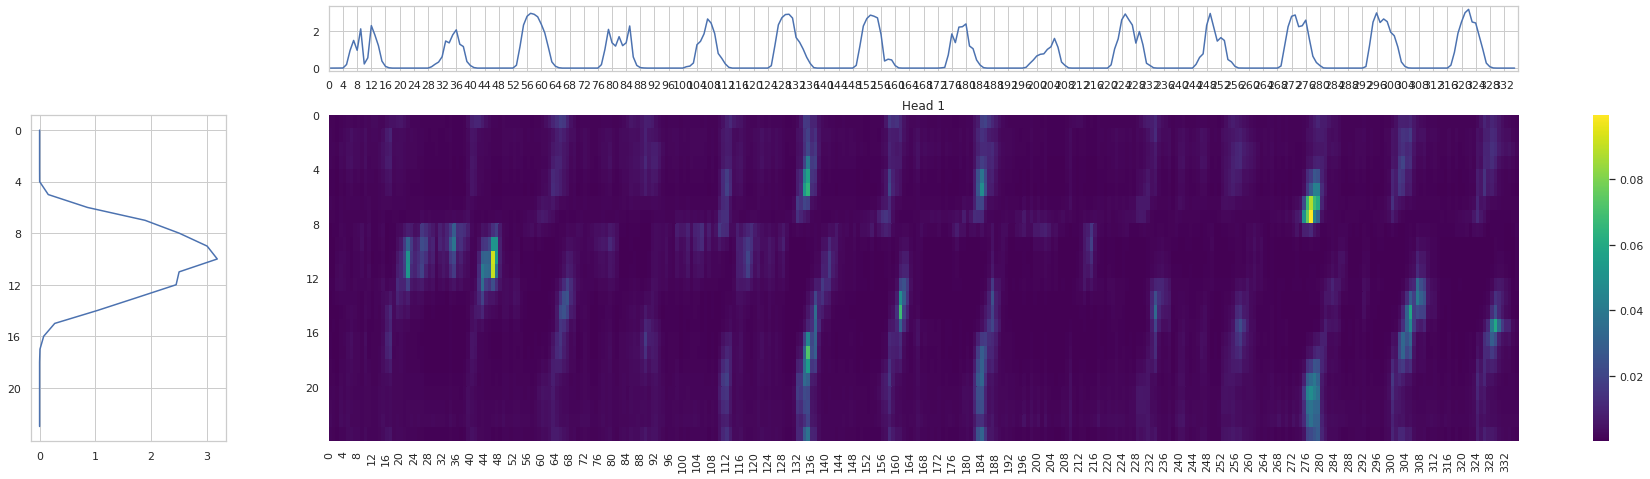

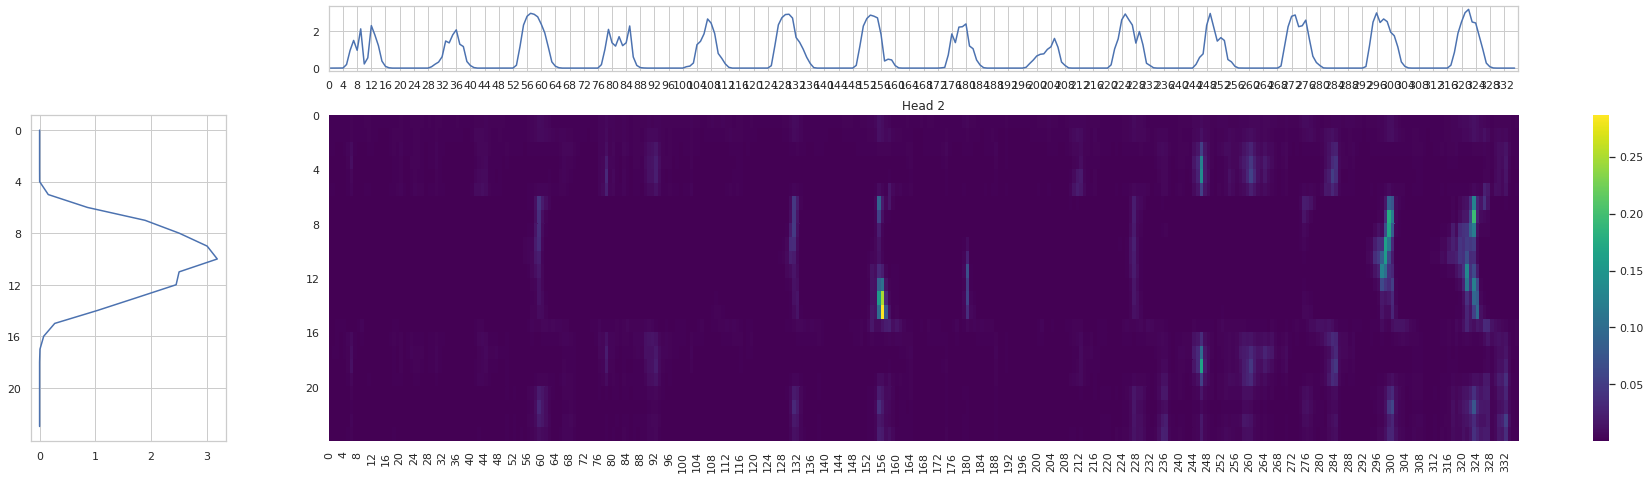

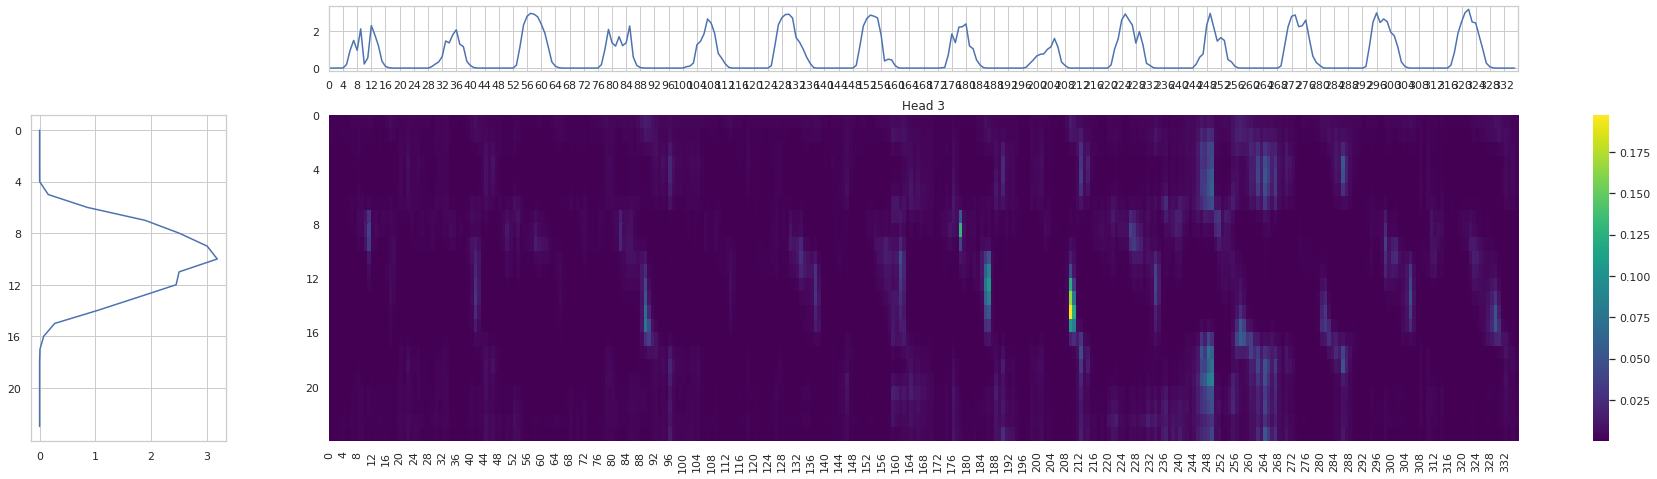

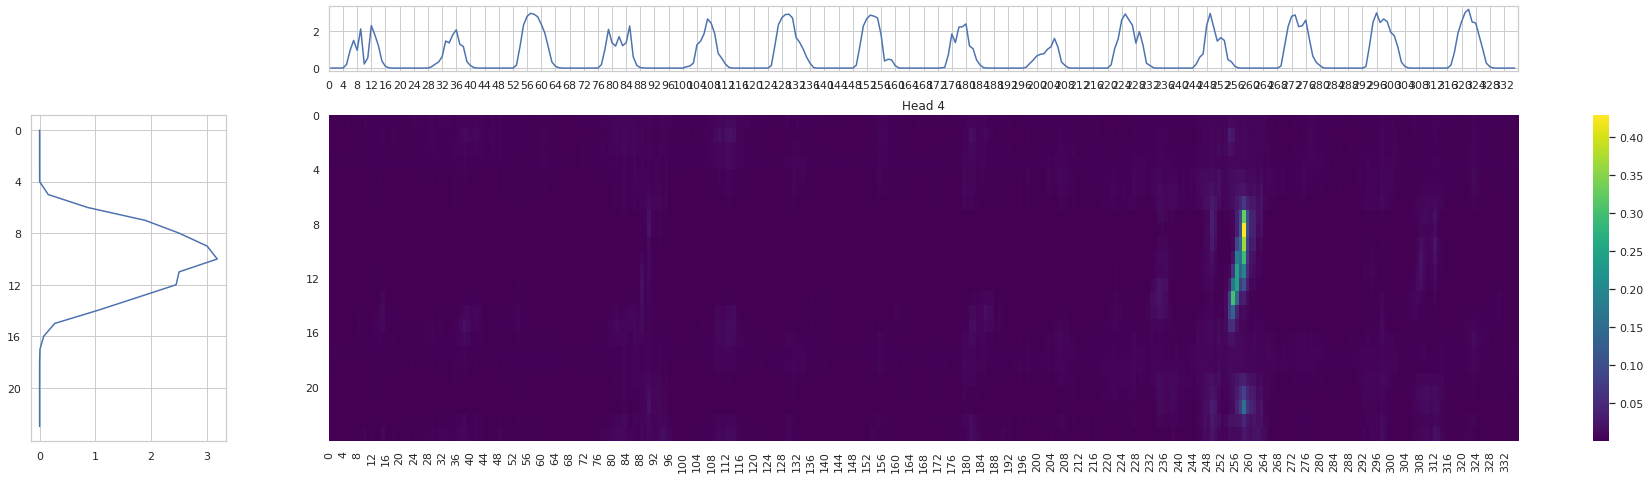

In [ ]:
idx = -10

num_steps_display = timesteps_in

attention = attention_weights
attention = tf.squeeze(attention["decoder_layer1_block2"][idx:idx+1], axis=0)

for head in range(0, num_heads):
  fig = plt.figure(figsize=(32,8))
  spec = gridspec.GridSpec(ncols=90, nrows=100)
  
  top_ax = fig.add_subplot(spec[0:15, 15:75])
  left_ax = fig.add_subplot(spec[25:, 0:10])
  right_ax = fig.add_subplot(spec[25:, 15:])
  
  top_ax.plot(x_train[idx, :num_steps_display, 0])
  top_ax.set_xlim([0, num_steps_display])
  top_ax.set_xticks(range(0, num_steps_display, 4))
  top_ax.set_xticklabels(range(0, num_steps_display, 4))

  left_ax.plot(decoder_input[idx, :, 0], range(0, timesteps_out))
  left_ax.set_yticks(range(0, timesteps_out, 4))
  left_ax.set_yticklabels(range(0, timesteps_out, 4))
  left_ax.invert_yaxis()

  sns.heatmap(attention[head][:, :num_steps_display], cmap="viridis", ax=right_ax)
  right_ax.set_xticks(range(0, num_steps_display, 4))
  right_ax.set_xticklabels(range(0, num_steps_display, 4))
  right_ax.set_yticks(range(0, timesteps_out, 4))
  right_ax.set_yticklabels(range(0, timesteps_out, 4))

  plt.title("Head {}".format(head+1))
  plt.show()

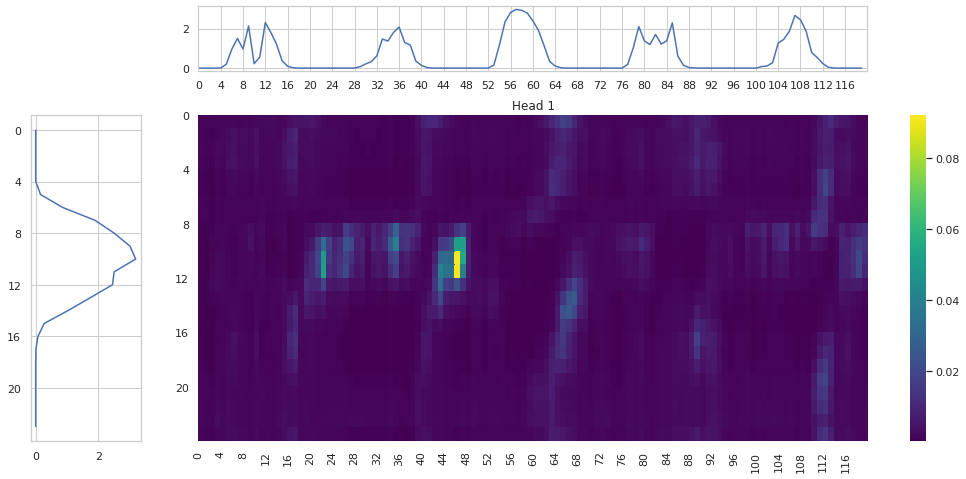

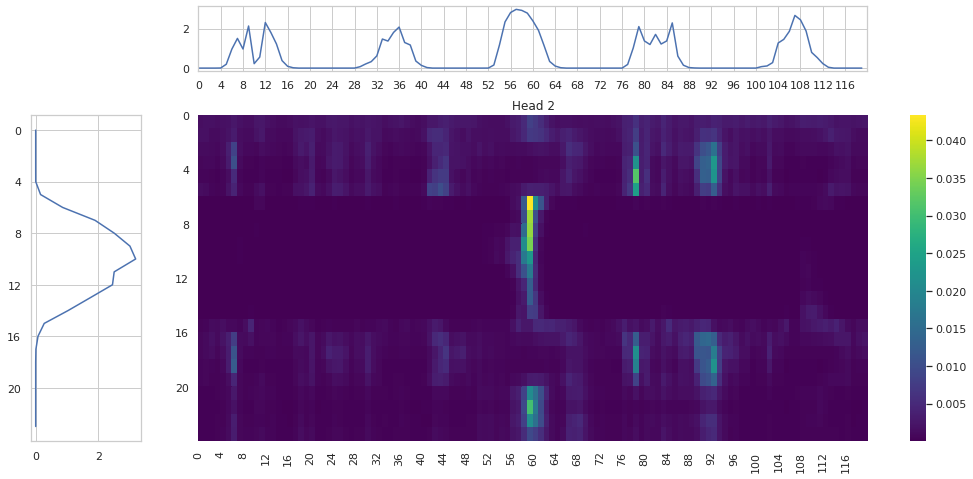

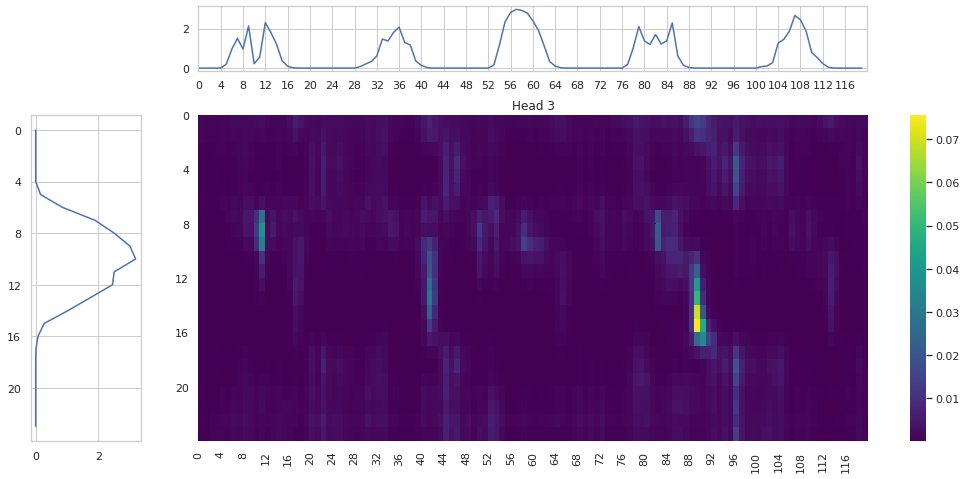

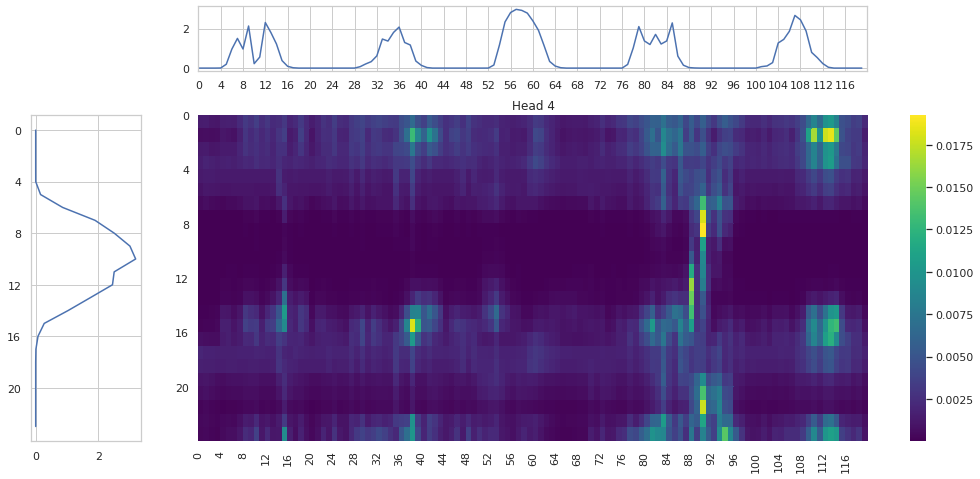

In [ ]:
idx = -10

num_steps_display = 120

attention = attention_weights
attention = tf.squeeze(attention["decoder_layer1_block2"][idx:idx+1], axis=0)

for head in range(0, num_heads):
  fig = plt.figure(figsize=(18,8))
  spec = gridspec.GridSpec(ncols=90, nrows=100)
  
  top_ax = fig.add_subplot(spec[0:15, 15:75])
  left_ax = fig.add_subplot(spec[25:, 0:10])
  right_ax = fig.add_subplot(spec[25:, 15:])
  
  top_ax.plot(x_train[idx, :num_steps_display, 0])
  top_ax.set_xlim([0, num_steps_display])
  top_ax.set_xticks(range(0, num_steps_display, 4))
  top_ax.set_xticklabels(range(0, num_steps_display, 4))

  left_ax.plot(decoder_input[idx, :, 0], range(0, timesteps_out))
  left_ax.set_yticks(range(0, timesteps_out, 4))
  left_ax.set_yticklabels(range(0, timesteps_out, 4))
  left_ax.invert_yaxis()

  sns.heatmap(attention[head][:, :num_steps_display], cmap="viridis", ax=right_ax)
  right_ax.set_xticks(range(0, num_steps_display, 4))
  right_ax.set_xticklabels(range(0, num_steps_display, 4))
  right_ax.set_yticks(range(0, timesteps_out, 4))
  right_ax.set_yticklabels(range(0, timesteps_out, 4))

  plt.title("Head {}".format(head+1))
  plt.show()

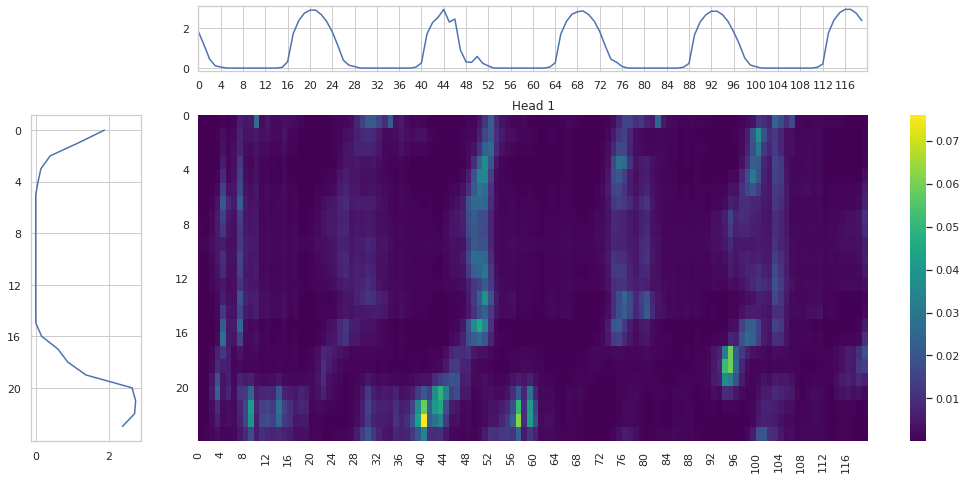

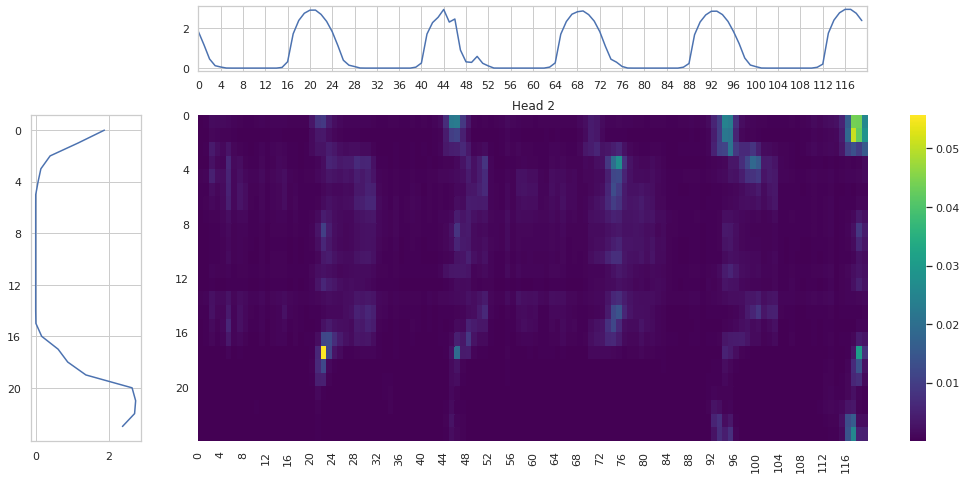

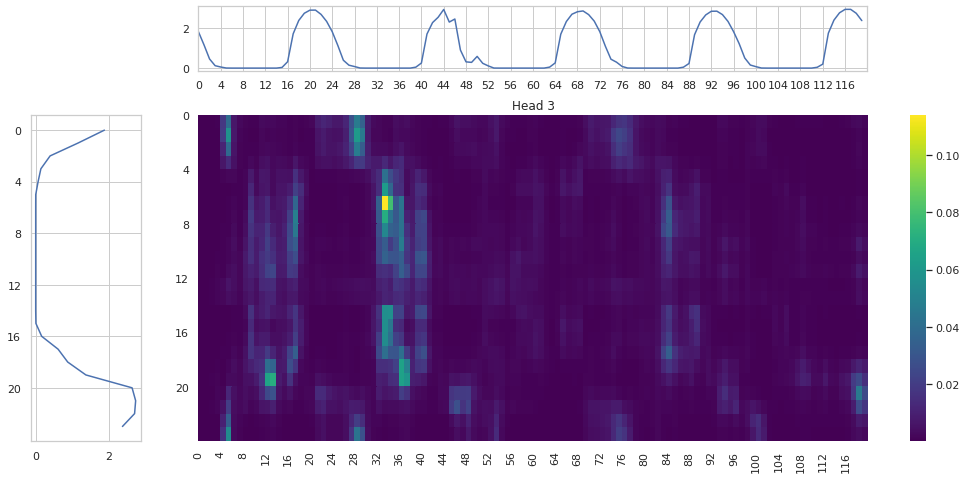

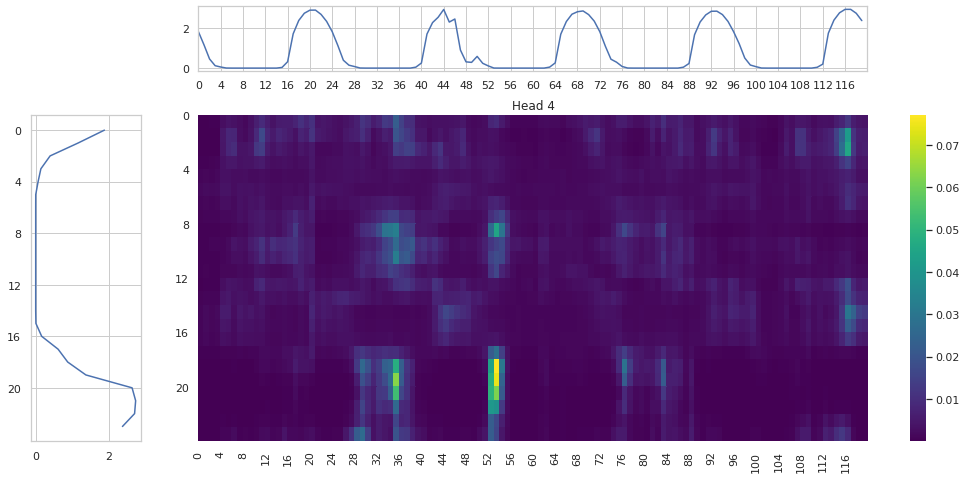

In [ ]:
idx = -15

num_steps_display = 120

attention = attention_weights
attention = tf.squeeze(attention["decoder_layer1_block2"][idx:idx+1], axis=0)

for head in range(0, num_heads):
  fig = plt.figure(figsize=(18,8))
  spec = gridspec.GridSpec(ncols=90, nrows=100)
  
  top_ax = fig.add_subplot(spec[0:15, 15:75])
  left_ax = fig.add_subplot(spec[25:, 0:10])
  right_ax = fig.add_subplot(spec[25:, 15:])
  
  top_ax.plot(x_train[idx, :num_steps_display, 0])
  top_ax.set_xlim([0, num_steps_display])
  top_ax.set_xticks(range(0, num_steps_display, 4))
  top_ax.set_xticklabels(range(0, num_steps_display, 4))

  left_ax.plot(decoder_input[idx, :, 0], range(0, timesteps_out))
  left_ax.set_yticks(range(0, timesteps_out, 4))
  left_ax.set_yticklabels(range(0, timesteps_out, 4))
  left_ax.invert_yaxis()

  sns.heatmap(attention[head][:, :num_steps_display], cmap="viridis", ax=right_ax)
  right_ax.set_xticks(range(0, num_steps_display, 4))
  right_ax.set_xticklabels(range(0, num_steps_display, 4))
  right_ax.set_yticks(range(0, timesteps_out, 4))
  right_ax.set_yticklabels(range(0, timesteps_out, 4))

  plt.title("Head {}".format(head+1))
  plt.show()